In [188]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob




def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))

    try: 
        data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))
    except Exception:
        pass
    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    try:
        data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"].iloc[1:]))
        data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"].iloc[1:]))
    except Exception:
        pass


    return data

def decodeAttributes(string):
    dict={}
    desc=string.split(";")
    for attribute in desc:
        dict[attribute[0]] = float(attribute[1:])
    return dict["p"], dict["a"], dict["l"], dict["s"]

def getPossibleVals(data):
    pointinessVals=[]
    spacingVals=[]
    lengthVals=[]
    for i in data:
        if round(i.attrs["pointiness"],3) not in pointinessVals: pointinessVals.append(round(i.attrs["pointiness"],3))
        if i.attrs["length"] not in lengthVals: lengthVals.append(i.attrs["length"])
        if i.attrs["spacing"] not in spacingVals: spacingVals.append(i.attrs["spacing"])

    pointinessVals.sort()
    spacingVals.sort()
    lengthVals.sort()

    return pointinessVals, spacingVals, lengthVals

def getRuns(spacing,pointiness,length):
    minDist=None
    bestRun=None

    runs=[]
    for run in data:
        dist=abs(run.attrs["spacing"]-spacing)*1e9+abs(run.attrs["pointiness"]-pointiness)+abs(run.attrs["length"]-length)*1e9
        if dist<0.001:
            runs.append(run)
    
    return runs



data=[]
filePrefix="data/"
for name in glob.glob(filePrefix+"*.out"):
    thisData=loadFile(name+"/table.txt")
    desc=name[len(filePrefix):-len(".out")]
    pointiness, spacing, length, runNum = decodeAttributes(desc)

    thisData.attrs["pointiness"]=pointiness
    thisData.attrs["spacing"]=spacing
    thisData.attrs["length"]=length
    thisData.attrs["runNum"]=runNum

    data.append(thisData)

pointinessVals, spacingVals, lengthVals = getPossibleVals(data)
print(getPossibleVals(data))



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framewor

([0.0, 0.1, 0.2, 0.267, 0.296, 0.3, 0.348, 0.4, 0.444, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [2.8e-07, 3.0000000000000004e-07, 3.2e-07, 3.4000000000000003e-07, 3.6000000000000005e-07, 3.8e-07, 4.0000000000000003e-07, 4.2e-07, 4.4e-07, 5.12e-07, 1.024e-06], [1.8000000000000002e-07, 2.0000000000000002e-07, 2.3000000000000002e-07, 2.7e-07, 3.0000000000000004e-07])


In [189]:
def indexOfSame(arr):
    if arr[0]==arr[1] or arr[0]==arr[2]:
        return 0
    if arr[1] == arr[2]:
        return 1

def selectRunIndex(runs):
    Brs = np.array([run.attrs["Br"] for run in runs])
    Hcs = np.array([run.attrs["Hc"] for run in runs])
    Mys = np.array([min(run["hIsland_my"]) for run in runs])

    allAgree=True
    selectedI=None
    for i in [0,1,2]:
        for j in [0,1,2]:
            if i==j: continue

            if(abs(Brs[i]-Brs[j])<0.001 and abs(Hcs[i]-Hcs[j])<1 and abs(Mys[i]-Mys[j]) < 0.001):
                selectedI=i
            else:
                allAgree=False
    
    return allAgree, selectedI



def removeDuplicateRuns(data):
    newData=[]
    numFixes=0
    totalRunCount=0
    unfixable=0
    insufficientTrials=0

    for pointiness in pointinessVals:
        for spacing in spacingVals:
            for length in lengthVals:
                runs=getRuns(spacing,pointiness,length)
                if len(runs)<3:
                    if len(runs)>0:
                        insufficientTrials+=1
                    continue
                if len(runs)>3:
                    runs=runs[0:3]

                    
                totalRunCount+=1


                Brs = np.array([run.attrs["Br"] for run in runs])
                Hcs = np.array([run.attrs["Hc"] for run in runs])
                Mys = np.array([min(run["hIsland_my"]) for run in runs])

                
                
                allAgree, i = selectRunIndex(runs)

                if not allAgree: numFixes += 1

                if i is None:
                    print(f"Inconsistent data for {pointiness}, {spacing}, {length}")
                    unfixable+=1
                    continue

                newData.append(runs[i])

    print(f"Fixed data for {numFixes}/{totalRunCount} runs. {unfixable} runs unfixable, {insufficientTrials} not enough data")
    return newData

data = removeDuplicateRuns(data)



                



Inconsistent data for 0.1, 3.0000000000000004e-07, 1.8000000000000002e-07
Inconsistent data for 0.1, 3.0000000000000004e-07, 2.0000000000000002e-07
Inconsistent data for 0.1, 3.4000000000000003e-07, 2.3000000000000002e-07
Inconsistent data for 0.1, 3.8e-07, 2.7e-07
Inconsistent data for 0.2, 3.2e-07, 2.3000000000000002e-07
Inconsistent data for 0.6, 4.0000000000000003e-07, 2.0000000000000002e-07
Fixed data for 46/474 runs. 6 runs unfixable, 1 not enough data


In [190]:


for pointiness in pointinessVals:
        for spacing in spacingVals:
            for length in lengthVals:
                runs=getRuns(spacing,pointiness,length)
                if len(runs)>1:
                    raise Exception()

                    

In [115]:
"""def getVals(string):
    if string=="length":
        return lengthVals
    elif string=="spacing":
        return spacingVals
    elif string=="pointiness":
        return pointinessVals

def getRunByAttributes(names,vals):
    for run in data:
        valid=True
        for i in range(len(names)):
            if(abs(run.attrs[names[i]]-vals[i])>10e-9):
                valid=False
        if valid:
            return run
def labelify(name):
    vals={
        "spacing":"Spacing (nm)",
        "length": "Length (nm)",
        "pointiness": "Pointiness",
        "Hc":"$H_c$",
        "Br":"$B_r",

    }
    if name in vals:
        return vals[name]
    else:
        return name

def legendify(val):
    if val<1e-5: val*=1e9
    val=round(val,1)
    return val

        
def plotData(yAxis,xAxis,colorAxis,plotAxis):
    plotAxisVals=getVals(plotAxis)
    colorAxisVals=getVals(colorAxis)
    xAxisVals=getVals(xAxis)

    plt.show()
    fig, axs = plt.subplots(2,int((len(plotAxisVals)+1)//2), sharex=True, sharey=True)

    for ax in axs.flat[len(plotAxisVals):]:
        ax.remove()

    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.set_size_inches(18,10)
    

    colors = mpl.cm.plasma(np.linspace(0,1,len(colorAxisVals)))
    colorLookup = dict(zip(colorAxisVals,colors))

    for i,plotVal in enumerate(plotAxisVals):
        ax=axs.flat[i]
        for colorVal in colorAxisVals:

            x=[]
            y=[]
            
            for xVal in xAxisVals:
                run=getRunByAttributes([plotAxis,colorAxis,xAxis],[plotVal,colorVal,xVal])
                
                if run is None: continue
                x.append(xVal)
                y.append(run.attrs[yAxis])

            ax.plot(x,y, "-o", color=colorLookup[colorVal])
        
        ax.text(0.5,.95,f"{labelify(plotAxis)}={legendify(plotVal)}",horizontalalignment='center',
        transform=ax.transAxes)

    fig.text(0.5, 0, labelify(xAxis), ha='center')
    fig.text(0, 0.5, labelify(yAxis), va='center', rotation='vertical')

    handles, labels = ax.get_legend_handles_labels()
    fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0,vmax=2)))

    fig.suptitle(f"{labelify(yAxis)} vs. {labelify(xAxis)}",y=1.05)

    fig.subplots_adjust(right=0.85)


plotData("Hc","spacing","pointiness","length")"""

'def getVals(string):\n    if string=="length":\n        return lengthVals\n    elif string=="spacing":\n        return spacingVals\n    elif string=="pointiness":\n        return pointinessVals\n\ndef getRunByAttributes(names,vals):\n    for run in data:\n        valid=True\n        for i in range(len(names)):\n            if(abs(run.attrs[names[i]]-vals[i])>10e-9):\n                valid=False\n        if valid:\n            return run\ndef labelify(name):\n    vals={\n        "spacing":"Spacing (nm)",\n        "length": "Length (nm)",\n        "pointiness": "Pointiness",\n        "Hc":"$H_c$",\n        "Br":"$B_r",\n\n    }\n    if name in vals:\n        return vals[name]\n    else:\n        return name\n\ndef legendify(val):\n    if val<1e-5: val*=1e9\n    val=round(val,1)\n    return val\n\n        \ndef plotData(yAxis,xAxis,colorAxis,plotAxis):\n    plotAxisVals=getVals(plotAxis)\n    colorAxisVals=getVals(colorAxis)\n    xAxisVals=getVals(xAxis)\n\n    plt.show()\n    fig, axs =

In [121]:

"""def makePlot(lengthVal):
    colors=plt.cm.plasma(pointinessVals)
    for i,pointiness in enumerate(pointinessVals):
        Hc=[]
        spacings=[]
        for spacing in spacingVals:
            thisRuns=getRuns(spacing,pointiness,lengthVal)
            for run in thisRuns:
                Hc.append(run.attrs["Br"])
                spacings.append(spacing*1e9)

        
        plt.plot(spacings,Hc,linestyle,color=colors[i],linewidth=2)
        
    cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Pointiness', rotation=270)
    plt.title(f"$B_r$ vs lattice spacing for varying pointiness (length={round(lengthVal*1e9)}nm)")
    plt.xlabel("a (nm)")
    plt.ylabel("$B_r$")


    plt.legend()
    plt.show()
print(spacingVals)
for lengthVal in lengthVals:
    makePlot(lengthVal)"""

'def makePlot(lengthVal):\n    colors=plt.cm.plasma(pointinessVals)\n    for i,pointiness in enumerate(pointinessVals):\n        Hc=[]\n        spacings=[]\n        for spacing in spacingVals:\n            thisRuns=getRuns(spacing,pointiness,lengthVal)\n            for run in thisRuns:\n                Hc.append(run.attrs["Br"])\n                spacings.append(spacing*1e9)\n\n        \n        plt.plot(spacings,Hc,linestyle,color=colors[i],linewidth=2)\n        \n    cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))\n    cbar.ax.get_yaxis().labelpad = 15\n    cbar.ax.set_ylabel(\'Pointiness\', rotation=270)\n    plt.title(f"$B_r$ vs lattice spacing for varying pointiness (length={round(lengthVal*1e9)}nm)")\n    plt.xlabel("a (nm)")\n    plt.ylabel("$B_r$")\n\n\n    plt.legend()\n    plt.show()\nprint(spacingVals)\nfor lengthVal in lengthVals:\n    makePlot(lengthVal)'

/var/folders/rl/cpjcq0556r36l75xt982r2kh0000gn/T/ipykernel_4825/551607642.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


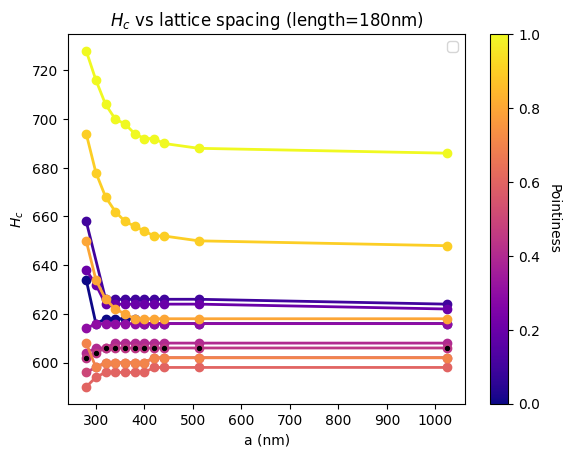

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


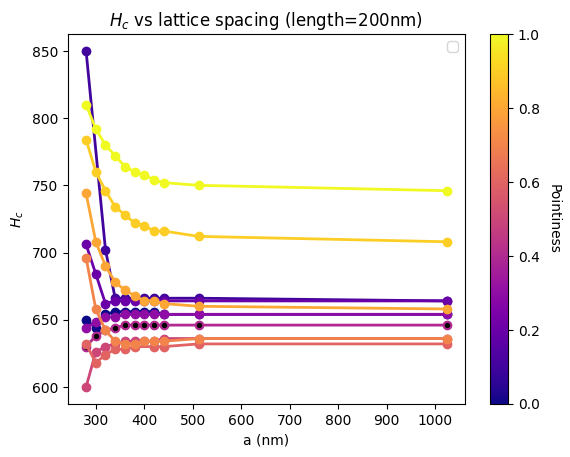

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


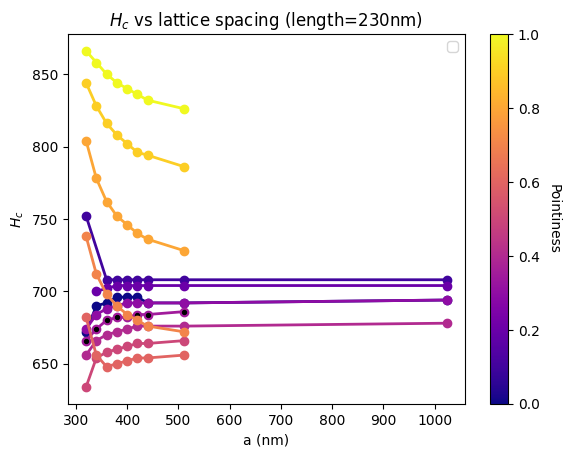

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


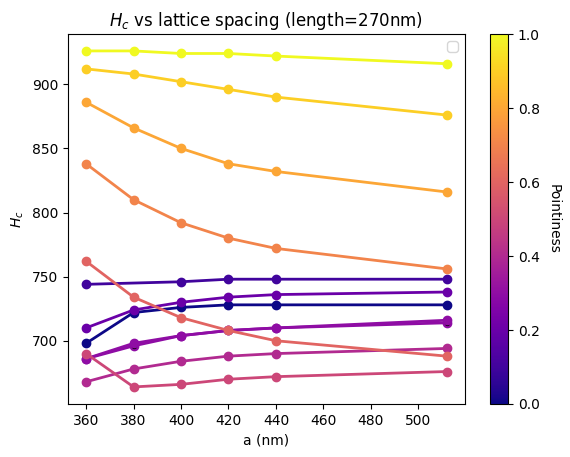

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


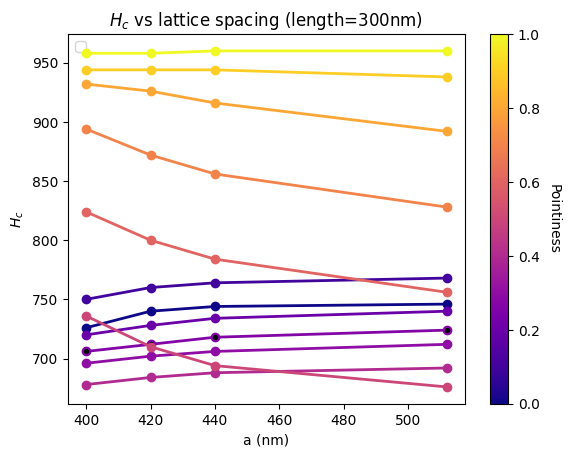

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


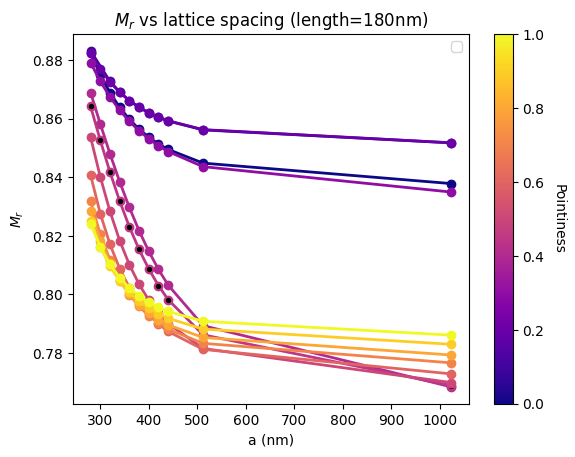

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


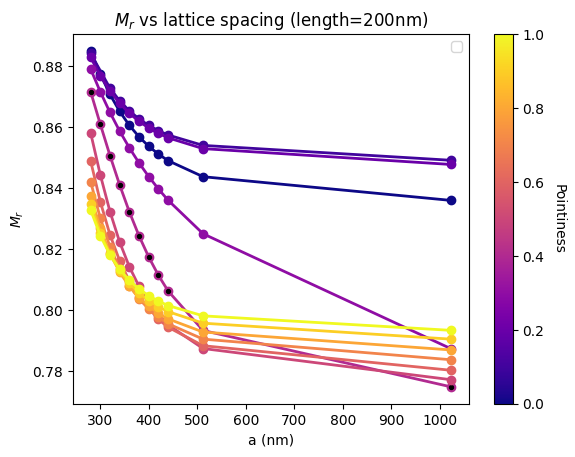

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


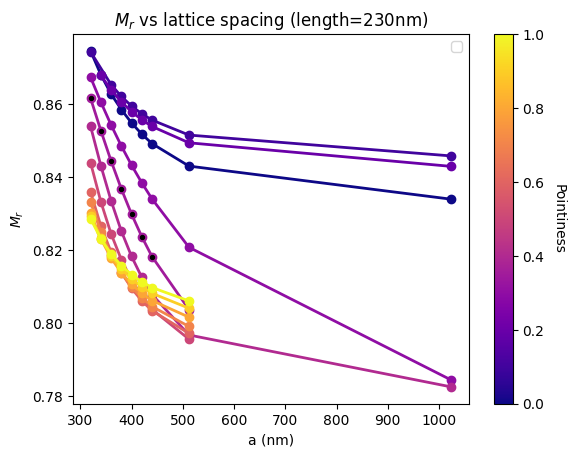

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


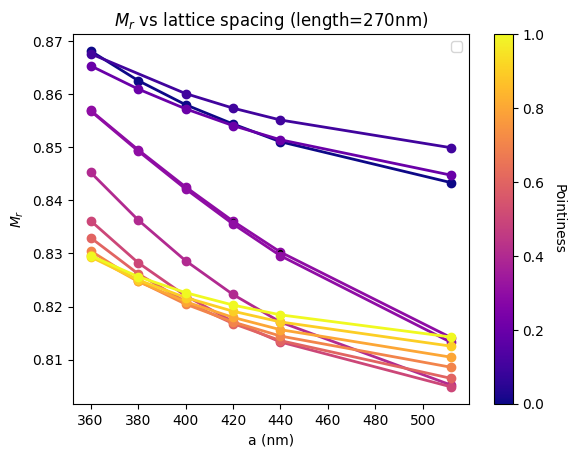

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


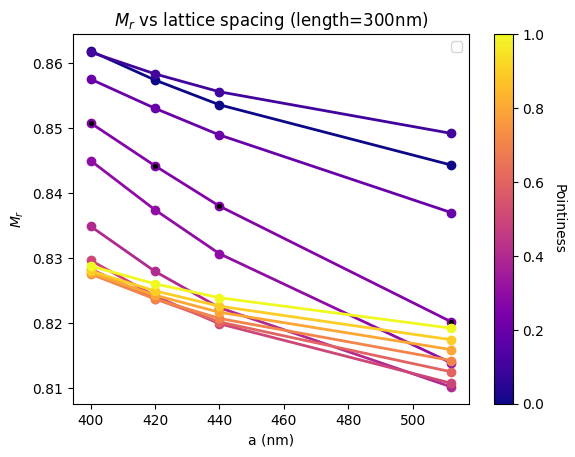

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


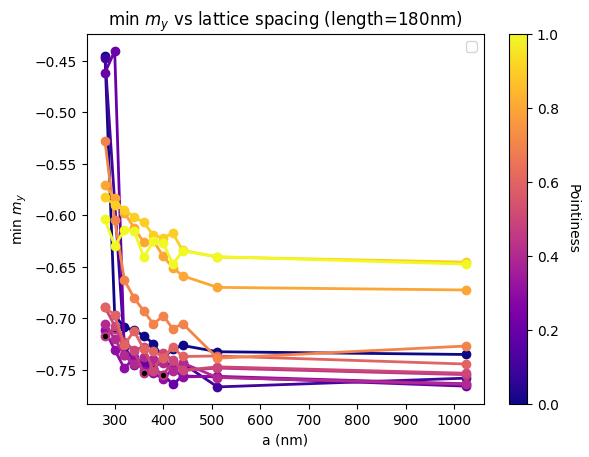

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


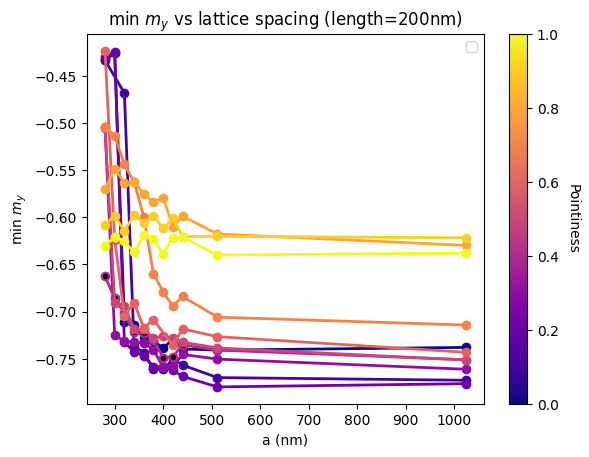

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


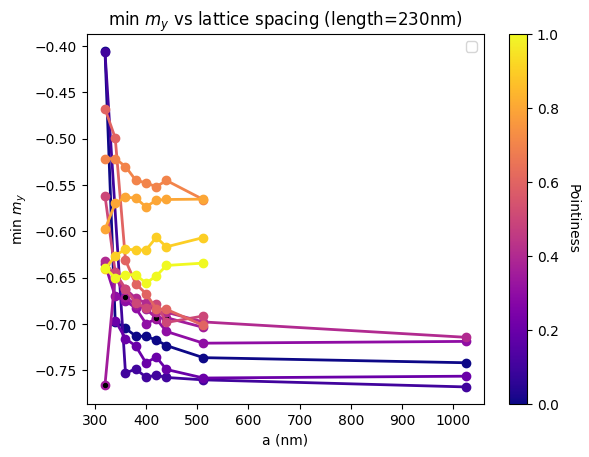

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


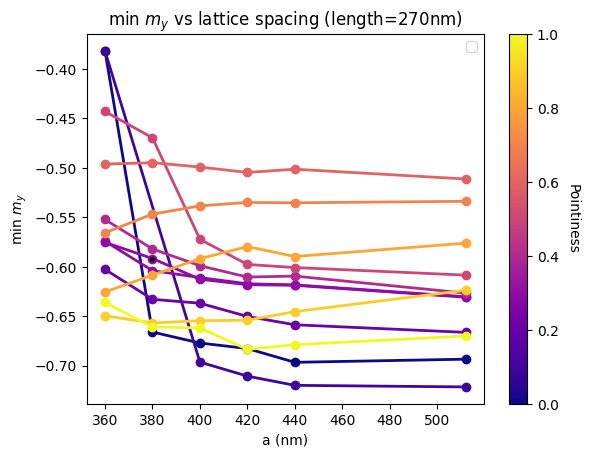

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


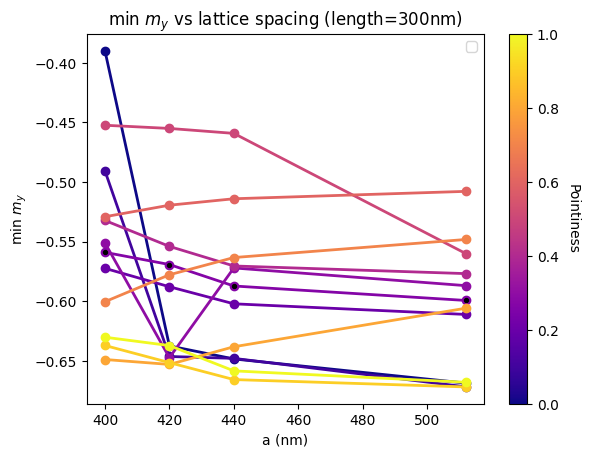

In [196]:
def makePlot(lengthVal,plotFunction,plotValue):
    colors=plt.cm.plasma(pointinessVals)
    for i,pointiness in enumerate(pointinessVals):
        Hc=[]
        spacings=[]
        blackX=[]
        blackY=[]
        
        for spacing in spacingVals:
            
            thisRuns=getRuns(spacing,pointiness,lengthVal)
            if len(thisRuns)==0:
                continue
            thisRun=thisRuns[0]
            Hc.append(plotFunction(thisRun))
            spacings.append(spacing*1e9)

            
            
            if abs(pointiness - 80/(1e9*lengthVal)) <0.001:
                
                blackX.append(spacing*1e9)
                blackY.append(plotFunction(thisRun))
                #print(blackX)

        plt.scatter(blackX,blackY,color="k",s=8,zorder=i+0.5)
        plt.plot(spacings,Hc,"o-",color=colors[i],linewidth=2,zorder=i)
        
        
    cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Pointiness', rotation=270)
    plt.title(f"{plotValue} vs lattice spacing (length={round(lengthVal*1e9)}nm)")
    plt.xlabel("a (nm)")
    plt.ylabel(plotValue)


    plt.legend()
    plt.show()
    
for lengthVal in lengthVals:
    makePlot(lengthVal,lambda run:run.attrs["Hc"],plotValue="$H_c$")

for lengthVal in lengthVals:
    makePlot(lengthVal,lambda run:run.attrs["Br"],plotValue="$M_r$")

for lengthVal in lengthVals:
    makePlot(lengthVal,lambda run:np.min(run["hIsland_my"]),plotValue="min $m_y$")

/var/folders/rl/cpjcq0556r36l75xt982r2kh0000gn/T/ipykernel_4825/3043515413.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma",
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


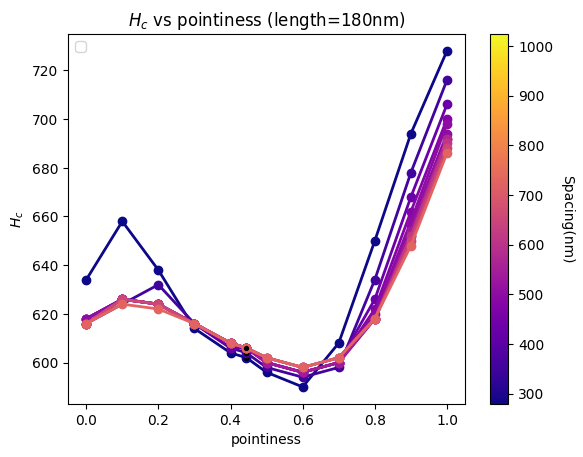

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


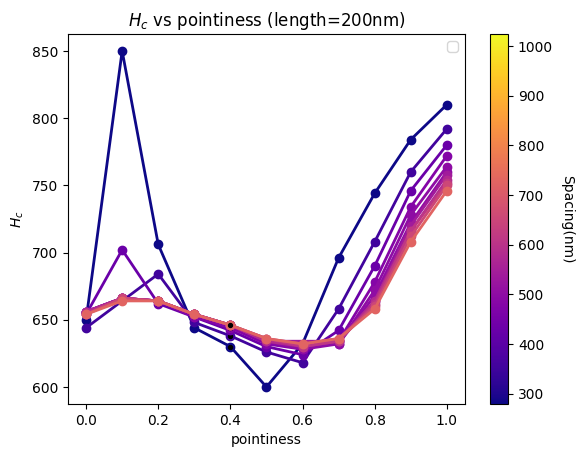

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


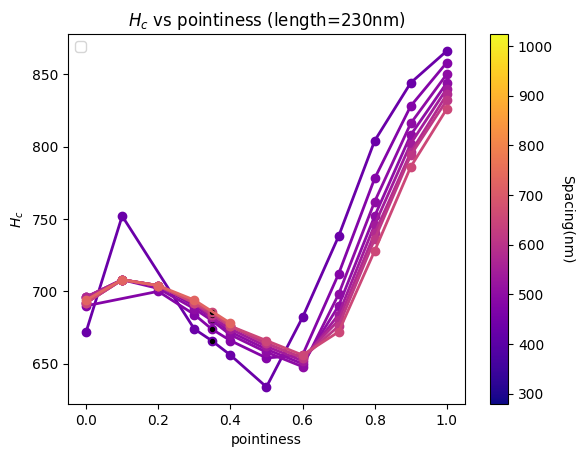

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


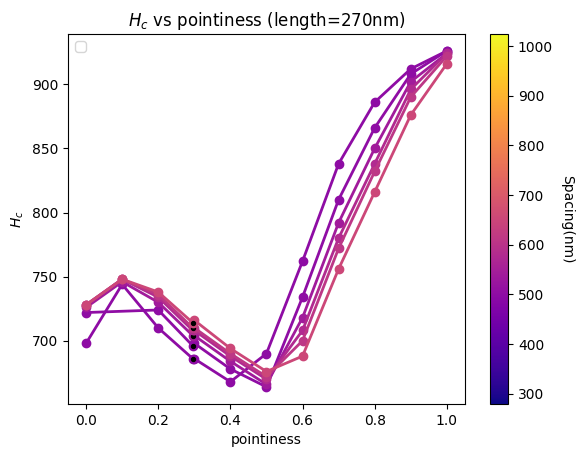

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


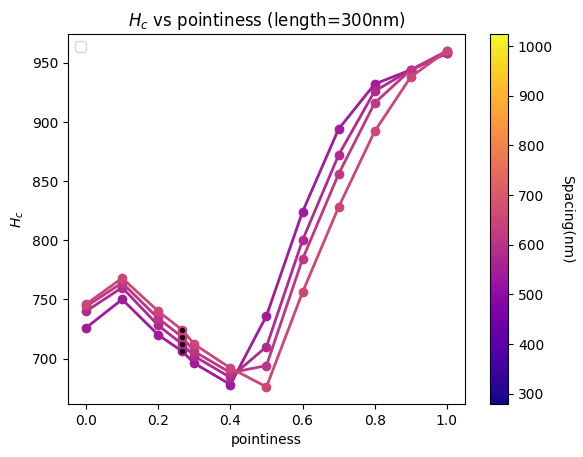

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


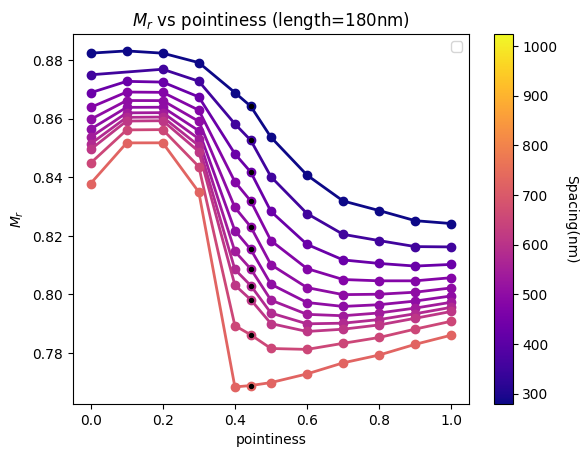

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


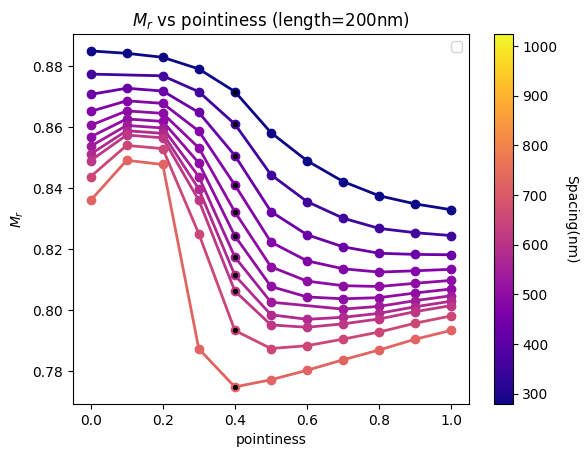

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


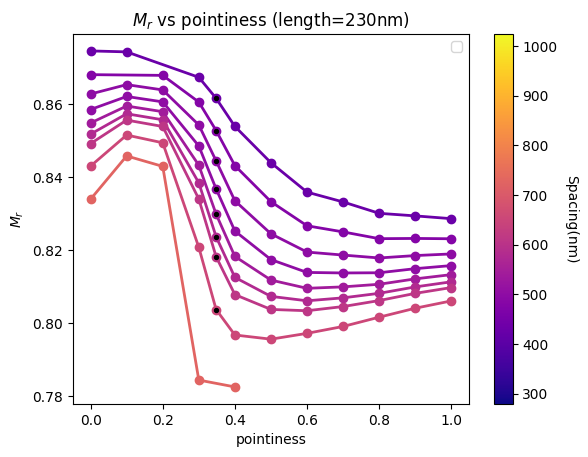

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


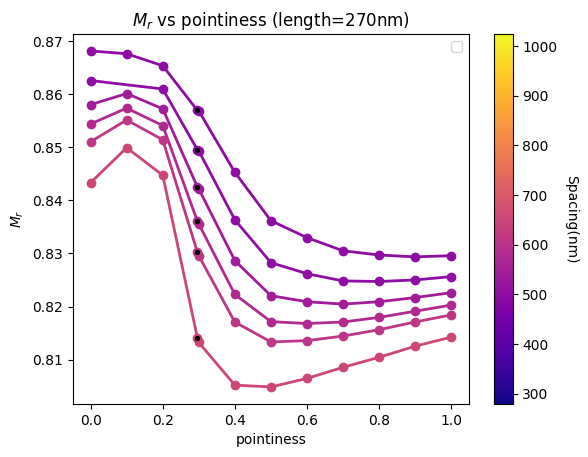

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


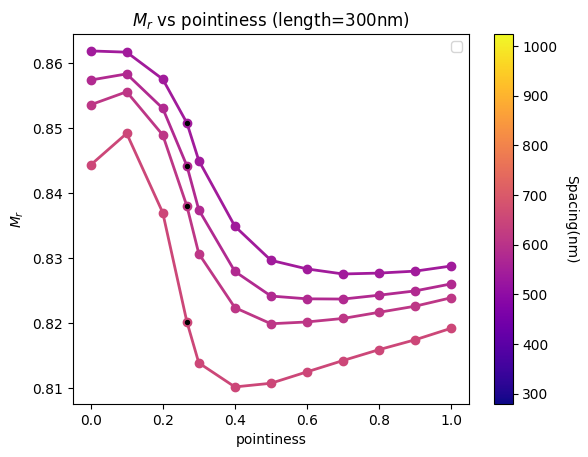

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


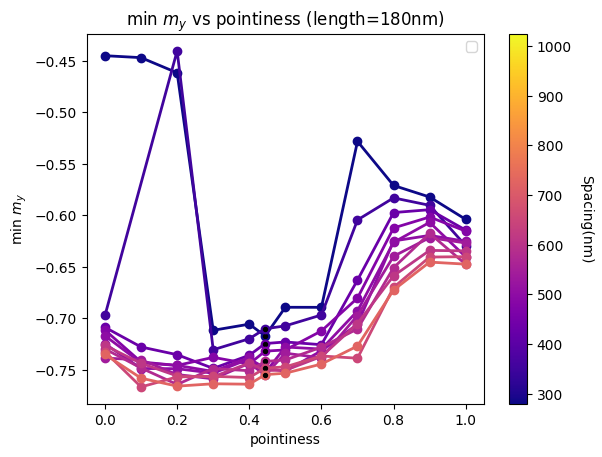

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


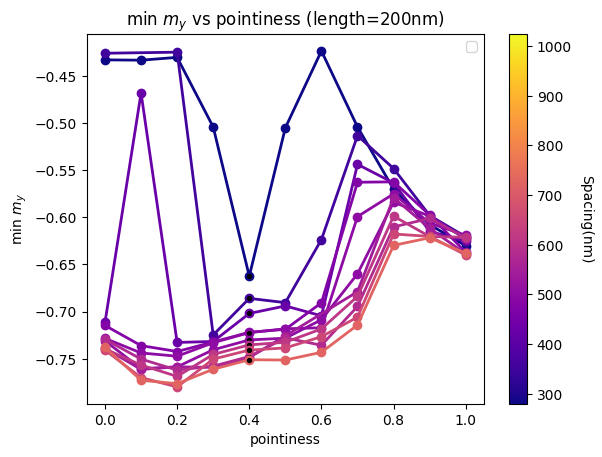

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


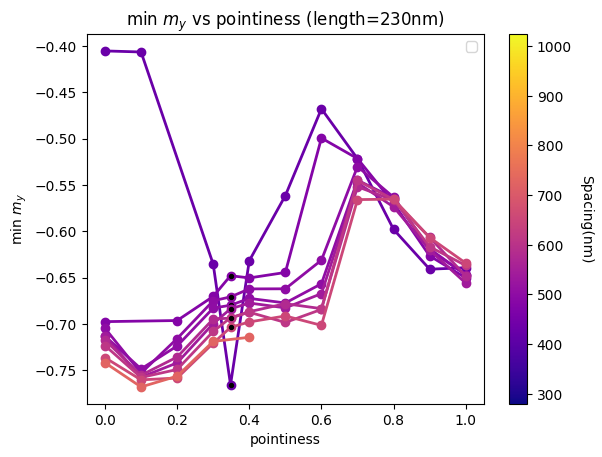

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


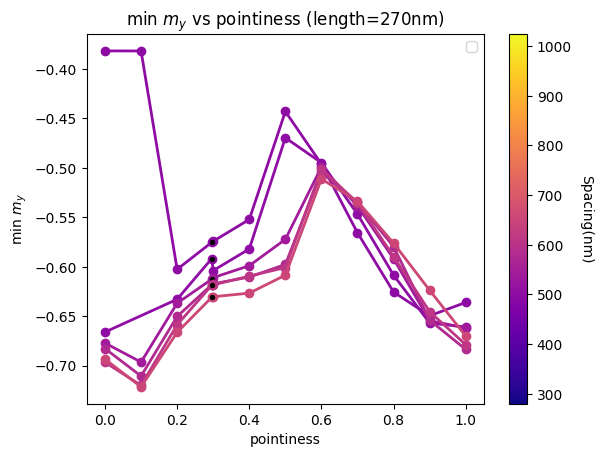

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


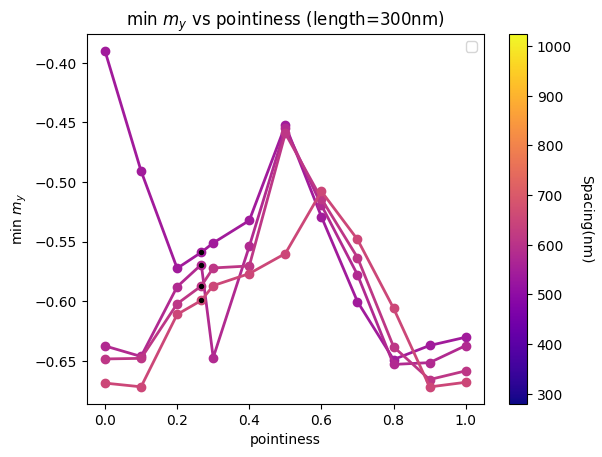

In [210]:
def makePlot(lengthVal,plotFunction,plotValue):
    colors=plt.cm.plasma(pointinessVals)
    for i,spacing in enumerate(spacingVals):
        Hc=[]
        pointinesses=[]
        blackX=[]
        blackY=[]
        
        for pointiness in pointinessVals:
            
            thisRuns=getRuns(spacing,pointiness,lengthVal)
            if len(thisRuns)==0:
                continue
            thisRun=thisRuns[0]
            Hc.append(plotFunction(thisRun))
            pointinesses.append(pointiness)

            
            
            if abs(pointiness - 80/(1e9*lengthVal)) <0.001:
                
                blackX.append(pointiness)
                blackY.append(plotFunction(thisRun))
                #print(blackX)

        plt.scatter(blackX,blackY,color="k",s=8,zorder=i+0.5)
        plt.plot(pointinesses,Hc,"o-",color=colors[i],linewidth=2,zorder=i)
        
        
    cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma",
        norm=mpl.colors.Normalize(vmin=min(spacingVals)*1e9,vmax=max(spacingVals)*1e9)
    ))
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Spacing(nm)', rotation=270)
    plt.title(f"{plotValue} vs pointiness (length={round(lengthVal*1e9)}nm)")
    plt.xlabel("pointiness")
    plt.ylabel(plotValue)


    plt.legend()
    plt.show()
    
for lengthVal in lengthVals:
    makePlot(lengthVal,lambda run:run.attrs["Hc"],plotValue="$H_c$")

for lengthVal in lengthVals:
    makePlot(lengthVal,lambda run:run.attrs["Br"],plotValue="$M_r$")

for lengthVal in lengthVals:
    makePlot(lengthVal,lambda run:np.min(run["hIsland_my"]),plotValue="min $m_y$")